In [3]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd, os
from datetime import datetime
import numpy as np 
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, SCORERS
from sklearn.model_selection import validation_curve
from xgboost import XGBRegressor, XGBClassifier
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json
import joblib
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [27]:
# Definition des Flags
flag_features = "v0" # v0 v1 v2
flag_train = 0 
flag_test = 1 

# Mise en forme des données de test

In [22]:
path_data_label = "data_redd/bat_2/fridge_test_bat_2.csv"
path_data_main = "data_redd/bat_2/main_bat_2.csv"

df = pd.read_csv(path_data_label,header=1)
df_ = pd.read_csv(path_data_main,header=1)

need_to_convert_unix_to_dt = 0
need_to_rename_first_column_to_date = 1

if need_to_rename_first_column_to_date == 1:
    
    df.rename(columns={df.columns[0]: 'Date'},
              inplace=True, errors='raise')
    df_.rename(columns={df_.columns[0]: 'Date'},
              inplace=True, errors='raise')
    

if need_to_convert_unix_to_dt == 1 : 
    def convert_ts(ts):
        return(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

    # format index dataframe
    df['unix_ts'] = df['unix_ts'].apply(lambda x:convert_ts(x))   
    df.rename(columns={'unix_ts': 'Date'},
              inplace=True, errors='raise')

df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

df_ = df_.set_index('Date')
df_.index = pd.to_datetime(df_.index)

#df = df.astype(float).dtypes
#df_ = df_.astype(float).dtypes

# drop 
#df = df.drop(['ihd'],axis=1)

# Format matrice features
if flag_features == "v0":

    df.rename(columns={df.columns[0]: 'instant'},inplace=True, errors='raise')
    df_general = pd.DataFrame(df['instant'])
    df_general['mean_5'] = df_general['instant'].rolling(5).mean()
    df_general['mean_120'] = df_general['instant'].rolling(120).mean()
    df_general['std_5'] = df_general['instant'].rolling(5).std()
    df_general['min_5'] = df_general['instant'].rolling(5).min()
    df_general['max_5'] = df_general['instant'].rolling(5).max()
    df_general = df_general.dropna()

if flag_features == "v1":
    
    # valeur des pas de temps précédents en features 
    df.rename(columns={df.columns[0]: 'instant'},inplace=True, errors='raise')
    df_general = pd.DataFrame(df['instant'])
    L = [[],[],[],[],[],[],[],[],[]]
    for i in range(len(L)) :
        for j in range(i,len(df_general)):
            L[i].append(df_general["instant"][j])
        df_general["L" + str(i)] = np.nan
        df_general["L" + str(i)][i:len(df_general)] = L[i]
    df_general = df_general.dropna()
    
# Format matrice label
df_label = df_
df_label = df_label.loc[df_general.index]

# ecriture des csv
df_general.to_csv("data_redd/bat_2/features.csv")
df_label.to_csv("data_redd/bat_2/label.csv")


In [23]:
# Lecture des fichiers de données 
path_x_train_1 = "data_redd/features_train.csv"
path_y_train_1 = "data_redd/labels_train.csv"
path_x_train_2 = "data_redd/features_test.csv"
path_y_train_2 = "data_redd/labels_test.csv"

path_x_test = "data_redd/bat_2/features.csv"
path_y_test = "data_redd/bat_2/label.csv"

device = 'fridge'

# base initiale : REDD 
df_x_train_1 = pd.read_csv(path_x_train_1,index_col=0,parse_dates=True).dropna()
df_y_train_1 = pd.read_csv(path_y_train_1,index_col=0,parse_dates=True).dropna()
df_x_train_2 = pd.read_csv(path_x_train_2,index_col=0,parse_dates=True).dropna()
df_y_train_2 = pd.read_csv(path_y_train_2,index_col=0,parse_dates=True).dropna()

df_x_train = df_x_train_1.append(df_x_train_2)
df_y_train = df_y_train_1[device].append(df_y_train_2[device])

df_x_test = pd.read_csv(path_x_test,index_col=0,parse_dates=True).dropna()
df_y_test = pd.read_csv(path_y_test,index_col=0,parse_dates=True).dropna()

# bases de test : RAE 
# df_y_test.rename(columns={'sub8': 'fridge'},inplace=True, errors='raise')

# bases de test REDD 2 
df_y_test.rename(columns={'active': 'fridge'},inplace=True, errors='raise')

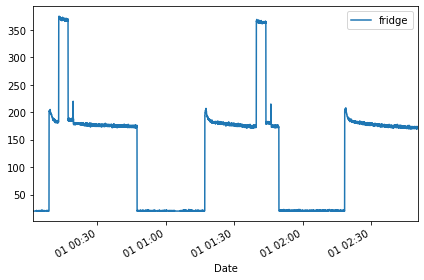

In [26]:
df_y_test[0:10000].plot()

# Entrainement et test du Random Forest

In [29]:
print("=============== création et entraînement des modèles ===============")

x_train = df_x_train.to_numpy()
y_train = df_y_train.to_numpy()

if flag_train == 1 :
    
    model_rf = RandomForestRegressor(n_estimators=100,max_depth=4,bootstrap=True)
    model_xgb = XGBRegressor(max_depth=6, n_estimators =200)

    model_rf.fit(x_train,y_train)
    print("rf score = ")
    print(model_rf.score(x_train,y_train))

    model_xgb.fit(x_train,y_train)
    print('xgb score = ')
    print(model_xgb.score(x_train,y_train))

    # enregistrer les modèles
    print("=============== enregistrement des modèles =============== ")
    joblib.dump(model_rf,"model_rf",compress=9)
    joblib.dump(model_xgb,"model_xgb",compress=9)

if flag_train == 0 : 
    
    model_rf = joblib.load("model_rf")
    model_xgb = joblib.load("model_xgb")
    
    print("rf score = ")
    print(model_rf.score(x_train,y_train))
    
    print('xgb score = ')
    print(model_xgb.score(x_train,y_train))

if flag_test == 1 :
    
    print("=============== test des modèles =============== ")
    
    # test du modèle RF
    x_test = df_x_test.to_numpy()
    y_test = df_y_test.to_numpy()

    df_predicted = pd.DataFrame(model_rf.predict(x_test),columns=["pred_rf"])
    df_predicted["pred_xgb"] = pd.DataFrame(model_xgb.predict(x_test))
    df_predicted['reel'] = pd.DataFrame(y_test)

    print("rmse rf :")
    print(mean_squared_error(df_predicted['reel'],df_predicted['pred_rf']))

    print("rmse xgb :")
    print(mean_squared_error(df_predicted['reel'],df_predicted['pred_xgb']))

=============== création et entraînement des modèles ===============
rf score = 
0.8002350269374386
xgb score = 


C:\ProgramData\Anaconda3\envs\nilmtk-env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9813987710155082
=============== test des modèles =============== 
rmse rf :
44617.45776633218
rmse xgb :
44869.80207182697


C:\ProgramData\Anaconda3\envs\nilmtk-env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


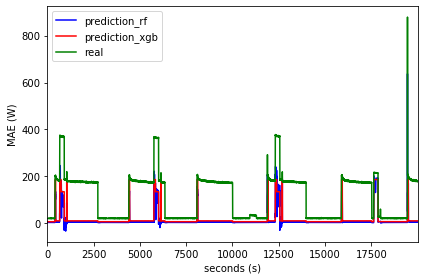

In [30]:
rmse_rf = round(np.sqrt(mean_squared_error(df_predicted['reel'],df_predicted['pred_rf'])),2)
mae_rf = round(mean_absolute_error(df_predicted['reel'],df_predicted['pred_rf']),2)

rmse_xgb = round(np.sqrt(mean_squared_error(df_predicted['reel'],df_predicted['pred_xgb'])),2)
mae_xgb = round(mean_absolute_error(df_predicted['reel'],df_predicted['pred_xgb']),2)

df_predicted['rmse_annotate'] = [-10 for elem in range(0,len(df_predicted))]
df_predicted['mae_annotate'] = [-10 for elem in range(0,len(df_predicted))]
df_predicted['rmse_annotate_'] = [-10 for elem in range(0,len(df_predicted))]
df_predicted['mae_annotate_'] = [-10 for elem in range(0,len(df_predicted))]

df_predicted[["pred_xgb","pred_rf","reel"]][0:20000].plot(color=['blue','red',"green",'white','white','white','white'])

#plt.yticks([0,50,100,150])
plt.ylabel('MAE (W)')
plt.xlabel('seconds (s)')
plt.legend(['prediction_rf',"prediction_xgb",'real','RMSE_RF= ' + str(rmse_rf) + ' W','MAE_RF= ' + str(mae_rf) + ' W',
           'RMSE_XGB= ' + str(rmse_xgb) + ' W','MAE_XGB= ' + str(mae_xgb) + ' W'])
plt.savefig('result.png',dpi=200)

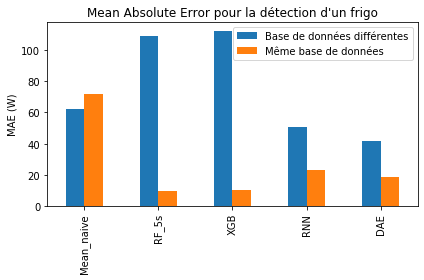

In [31]:
with open('result.json') as f:
    metric = json.load(f)

metric = {"Mean_naive":[62.3,71.56],"RF_5s":[mae_rf,9.91],"XGB":[mae_xgb,10.17],"RNN":[50.9,23.27],"DAE":[41.7,18.47]}

with open('result.json', 'w') as outfile:
    json.dump(metric, outfile)
    
df = pd.DataFrame(metric).transpose()
df.to_csv("result_.csv")

df.plot.bar()

plt.title("Mean Absolute Error pour la détection d'un frigo")
plt.legend(["Base de données différentes","Même base de données"])
plt.ylabel('MAE (W)')

plt.savefig('compare_adaptability.png',dpi=200)

In [26]:
df

,0,1
Mean_naive,62.30,71.56
RF_5s,75.62,9.91
XGB,175.30,10.17
RNN,50.90,23.27
DAE,41.70,18.47


# CLUSTERISATION - AJUSTEMENT POWER - RECREATION DES DONNEES DE TEST ET TRAIN

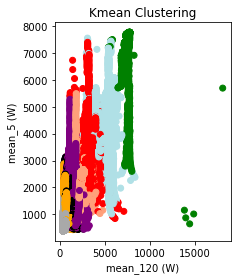

In [155]:
from sklearn.cluster import KMeans

X = df_x_test.to_numpy()

clustering = KMeans(n_clusters=8,random_state=3)
clustering.fit(X)
df_centroids = cpd.DataFrame(clustering.cluster_centers_,columns=df_x_test.columns)

color_theme = np.array(['darkgray','lightsalmon','powderblue','black','red','orange','green','purple'])
plt.subplot(1,2,1)
plt.scatter(x = df_x_test.instant,y=df_x_test.mean_120,c=color_theme[clustering.labels_])
plt.xlabel('mean_120 (W)')
plt.ylabel('mean_5 (W)')
plt.title('Kmean Clustering')
plt.savefig('clustering.png',dpi=200)


# Tracé des diagrammes de fréquence

In [32]:
df_x_train['instant']

type
2011-04-18 09:24:12-04:00    92.0
2011-04-18 09:24:13-04:00    92.0
2011-04-18 09:24:14-04:00    92.0
2011-04-18 09:24:15-04:00    92.0
2011-04-18 09:24:16-04:00    92.0
                             ... 
2011-05-03 17:33:13-04:00    91.0
2011-05-03 17:33:14-04:00    91.0
2011-05-03 17:33:15-04:00    91.0
2011-05-03 17:33:16-04:00    91.0
2011-05-03 17:33:17-04:00    90.0
Name: instant, Length: 1041486, dtype: float64

In [49]:
df_freq = df_x_train["mean_5"].value_counts(bins=400, sort=False)
df_freq.head(50)

(1.9640000000000002, 19.586]    349647
(19.586, 32.172]                  1077
(32.172, 44.759]                  1079
(44.759, 57.345]                  1837
(57.345, 69.931]                   213
(69.931, 82.518]                   242
(82.518, 95.104]                378776
(95.104, 107.69]                  1296
(107.69, 120.276]                  595
(120.276, 132.862]                1882
(132.862, 145.449]                 260
(145.449, 158.035]                 149
(158.035, 170.621]                 172
(170.621, 183.207]                2016
(183.207, 195.794]               42987
(195.794, 208.38]                49515
(208.38, 220.966]                 7971
(220.966, 233.552]                6119
(233.552, 246.139]                3495
(246.139, 258.725]                 791
(258.725, 271.311]               19994
(271.311, 283.898]               75398
(283.898, 296.484]               24062
(296.484, 309.07]                 4608
(309.07, 321.656]                 4082
(321.656, 334.242]       

In [52]:
df_freq_2 = df_x_test["instant"].value_counts(bins=400, sort=False)
df_freq_2.head(50)

(326.228, 388.428]        396
(388.428, 432.855]       6025
(432.855, 477.282]      13266
(477.282, 521.71]        9171
(521.71, 566.138]       53033
(566.138, 610.565]      32558
(610.565, 654.993]      32082
(654.993, 699.42]       65982
(699.42, 743.848]       35009
(743.848, 788.275]      39538
(788.275, 832.703]      38819
(832.703, 877.13]       27455
(877.13, 921.558]       31925
(921.558, 965.985]      23873
(965.985, 1010.412]     25358
(1010.412, 1054.84]     22669
(1054.84, 1099.268]     18226
(1099.268, 1143.695]    19592
(1143.695, 1188.122]    15093
(1188.122, 1232.55]     13201
(1232.55, 1276.978]     13468
(1276.978, 1321.405]    12342
(1321.405, 1365.832]     9928
(1365.832, 1410.26]      9172
(1410.26, 1454.688]      7909
(1454.688, 1499.115]     7816
(1499.115, 1543.542]     4934
(1543.542, 1587.97]      4413
(1587.97, 1632.398]      3789
(1632.398, 1676.825]     2534
(1676.825, 1721.252]     2476
(1721.252, 1765.68]      1826
(1765.68, 1810.108]      1061
(1810.108,

In [55]:
np.mean(df_y_test.loc[df_y_test.fridge > 10])

fridge    135.443564
dtype: float64

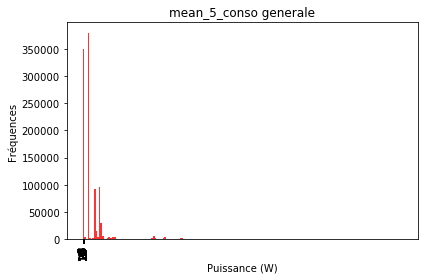

In [40]:
col = "mean_5"
plot = plt.hist(list(df_x_train[col]),bins=200,color="red",alpha=0.8)
plt.title(col + "_conso generale")
plt.ylabel("Fréquences")
plt.xlabel("Puissance (W)")
plt.xticks([n for n in range(1,30)],rotation='vertical')
plt.savefig("Hist" + "_" + col + "_.jpg", dpi=200)